## Load labels

In [1]:
from pathlib import Path

data_path = Path("../data")
data_path

WindowsPath('../data')

### List all WAV files

In [2]:
wav_files = data_path.glob("*.wav")
wav_files = list(wav_files)
wav_files[:5]

[WindowsPath('../data/03-01-01-01-01-01-01.wav'),
 WindowsPath('../data/03-01-01-01-01-01-02.wav'),
 WindowsPath('../data/03-01-01-01-01-01-03.wav'),
 WindowsPath('../data/03-01-01-01-01-01-04.wav'),
 WindowsPath('../data/03-01-01-01-01-01-05.wav')]

### Map file names to their classes.

Each emotion is labelled as 01 - 08, so we convert that to labels 0 - 7

In [3]:
def class_from_file_name(fname):
    return int(fname.split('-')[2]) - 1

labels = {
    f.name: class_from_file_name(f.name)
    for f in wav_files
}
[(k, v) for k, v in labels.items()][:5]

[('03-01-01-01-01-01-01.wav', 0),
 ('03-01-01-01-01-01-02.wav', 0),
 ('03-01-01-01-01-01-03.wav', 0),
 ('03-01-01-01-01-01-04.wav', 0),
 ('03-01-01-01-01-01-05.wav', 0)]

### Extract number of classes

In [4]:
NUM_CLASSES = len(set(labels.values()))
NUM_CLASSES

8

## Load Data

### Fix PYTHONPATH

Add the path to the vgg-related files to the pythonpath so that we can import the modules

In [5]:
import os
import sys
nb_dir = Path(os.getcwd())
vgg_dir = nb_dir.parent / 'vgg'
vgg_dir

WindowsPath('D:/Work/playground/vgg-emotion-classifier/vgg')

In [6]:
if str(vgg_dir) not in sys.path:
    sys.path.append(str(vgg_dir))
sys.path

['',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\python36.zip',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\DLLs',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib\\site-packages',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Sam\\.ipython',
 'D:\\Work\\playground\\vgg-emotion-classifier\\vgg']

### Read WAV files

Read in the wav files and convert them into the correct shape for the VGGish model (this is thankfully taken care of already by the example code provided)

In [7]:
from vggish_input import wavfile_to_examples 

In [8]:
data = {
    f.name: wavfile_to_examples(str(f))
    for f in wav_files
}

In [9]:
data['03-01-01-01-01-01-01.wav'].shape

(3, 96, 64)

### Convert labels to one-hot vectors

For multi-class classification using categorical crossentropy we want the labels in one-hot encoded form.

E.g. label `1` becomes `[0, 1, 0, 0 ,0 ,0, 0, 0]`

In [10]:
import numpy as np

y = np.array(list(labels.values()))
y_one_hot = np.zeros(((y.size, y.max()+1)))
y_one_hot[np.arange(y.size), y] = 1

### Split dataset

Split into

* train: 70%
* val: 15%
* test: 15%

In [11]:
from sklearn.model_selection import train_test_split

In [51]:
seed = 987234871

x_train_keys, x_test_keys, y_train, y_test = train_test_split(list(labels.keys()),
                                                    y_one_hot,
                                                    test_size = 0.15,
                                                    random_state = seed)

x_train_keys, x_val_keys, y_train, y_val = train_test_split(x_train_keys,
                                                            y_train,
                                                            test_size = 0.15 / (1 - 0.15),
                                                            random_state = seed)

x_train = np.array([data[key] for key in x_train_keys])
x_val = np.array([data[key] for key in x_val_keys])
x_test = np.array([data[key] for key in x_test_keys])

print(f"Training size: {len(x_train_keys)}")
print(f"Validation size: {len(x_val_keys)}")
print(f"Training size: {len(x_test_keys)}")

Training size: 1008
Validation size: 216
Training size: 216


In [52]:
y_train[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

### Compute balanced weights

The number of instances for each class isn't balanced, so we need to create weightings for each class to even things out during training

In [14]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(list(labels.values())),
                                                         list(labels.values()))
# class_weights = {c: w for c, w in enumerate(scikit_class_weights)}
# class_weights
# scikit_class_weights

Create function to convert class weights to sample weights

In [76]:
def sample_weights_from_class_weights(class_weights, labels):
    return np.array([class_weights[np.argmax(label)] for label in labels])

### Create function to get batches from data

In [57]:
from random import shuffle
def get_shuffled_batches(x, y):
    assert len(x) == len(y)
    indexes = list(range(len(x)))
    shuffle(indexes)
    for x, y in zip(x[indexes], y[indexes]):
        x_batch = np.reshape(x, (1, *x.shape, 1))
        y_batch = np.reshape(y, (1, *y.shape))
        yield x_batch, y_batch

## Convert pretrained TF weights to Keras model checkpoint

Don't want to deal with the TF library, Keras is much easier to use imo. That means we first need to turn the TF checkpoint into a Keras checkpoint.

It should theoretically be possible to load the TF checkpoint as is, but this way I know it'll work.

### Define exact VGGish model in Keras

Code taken from https://github.com/SNeugber/vggish2Keras, which is a clone of https://github.com/antoinemrcr/vggish2Keras

In [15]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
import vggish_params

def get_vggish_keras():
    input_shape = (vggish_params.NUM_FRAMES,vggish_params.NUM_BANDS,1)

    img_input = Input( shape=input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block fc
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1_1')(x)
    x = Dense(4096, activation='relu', name='fc1_2')(x)
    x = Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2')(x)


    model = Model(img_input, x, name='vggish')
    return model

Using TensorFlow backend.


### Load weights

Need to turn TF layer names into Keras layer names

In [16]:
import tensorflow as tf
import vggish_slim

with tf.Graph().as_default(), tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, '../pretrained_models/vggish_model.ckpt')

    weights = {}
    operations = sess.graph.get_operations()
    for op in operations:
        name = op.name
        if 'read' in name:
            name2 = name.replace('vggish/','').replace('/read','').replace('conv3/','').replace('conv4/','').replace('/fc1','')
            name2_layer, name2_type = name2.split('/')
            if name2_type == 'weights':
                weights[name2_layer] = []
                weights[name2_layer].append(sess.run(op.values())[0])

    for op in operations:
        name = op.name
        if 'read' in name:
            name2 = name.replace('vggish/','').replace('/read','').replace('conv3/','').replace('conv4/','').replace('/fc1','')
            name2_layer, name2_type = name2.split('/')
            if name2_type == 'biases':
                weights[name2_layer].append(sess.run(op.values())[0])

INFO:tensorflow:Restoring parameters from ../pretrained_models/vggish_model.ckpt


In [17]:
weights.keys()

dict_keys(['conv1', 'conv2', 'conv3_1', 'conv3_2', 'conv4_1', 'conv4_2', 'fc1_1', 'fc1_2', 'fc2'])

### Save as Keras model

In [18]:
model = get_vggish_keras()
model.summary()
for layer in model.layers:
    if layer.name in list(weights.keys()):
        layer.set_weights(weights[layer.name])
model.save_weights('../pretrained_models/vgg_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080    
__________

## Load VGGish model wrapped in TimeDistributed layer

The normal model only works on a single time-frame. We want to train on multiple frames, so we need to wrap everything in Keras' [TimeDistributed](https://keras.io/layers/wrappers/#TimeDistributed)

In [19]:
from keras.layers import TimeDistributed

def get_vggish_keras_timedistributed():
    input_shape = (None, vggish_params.NUM_FRAMES,vggish_params.NUM_BANDS,1)

    img_input = Input(shape=input_shape)
    # Block 1
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name='conv1')(img_input)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool1')(x)

    # Block 2
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool2')(x)

    # Block 3
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))(x)
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool3')(x)

    # Block 4
    x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))(x)
    x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool4')(x)

    # Block fc
    x = TimeDistributed(Flatten(), name='flatten')(x)
    x = TimeDistributed(Dense(4096, activation='relu'), name='fc1_1')(x)
    x = TimeDistributed(Dense(4096, activation='relu'), name='fc1_2')(x)
    x = TimeDistributed(Dense(vggish_params.EMBEDDING_SIZE, activation='relu'), name='fc2')(x)

    model = Model(img_input, x, name='vggish_across_time')
    return model

In [20]:
model = get_vggish_keras_timedistributed()

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 96, 64, 1)   0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, None, 96, 64, 64)  640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, None, 48, 32, 64)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 48, 32, 128) 73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, None, 24, 16, 128) 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 16, 256) 295168    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 24, 16, 256) 590080    
__________

In [22]:
model.load_weights('../pretrained_models/vgg_model.h5')

In [23]:
from keras.layers import CuDNNLSTM
from tensorflow import Tensor

x = CuDNNLSTM(127)(model.layers[-1].output)
x = Dense(8, activation='softmax', name='out')(x)

final_model = Model(inputs=model.input, outputs=[x])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 96, 64, 1)   0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, None, 96, 64, 64)  640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, None, 48, 32, 64)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 48, 32, 128) 73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, None, 24, 16, 128) 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 16, 256) 295168    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 24, 16, 256) 590080    
__________

## Train Model

Putting it all together

### Compile model

First we need to compile the model, for which we'll use the same parameters (for now) as used originally:
* Adam optimizer
* LR of 1e-4
* Adam Epsilon of 1e-8

In [24]:
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy

model = final_model
optimizer = Adam(lr=vggish_params.LEARNING_RATE, epsilon=vggish_params.ADAM_EPSILON)
metrics = [categorical_accuracy]
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

Since we're dealing with var-length data, we can't just call `fit`, but instead need to train on each batch manually.

In [58]:
def train_epoch(model, x_train, y_train):
    train_loss = 0.0
    train_batches = 0.0
    train_accuracy = 0.0
    
    for x, y in get_shuffled_batches(x_train, y_train):
        loss, acc = model.train_on_batch(x, y, class_weight=class_weights)

        train_loss += loss
        train_accuracy += acc
        train_batches += 1
    return train_loss / train_batches, train_accuracy / train_batches

In [81]:
def validate_epoch(model, x_val, y_val, class_weights):
    val_loss = 0.0
    val_batches = 0.0
    val_accuracy = 0.0

    for x, y in get_shuffled_batches(x_val, y_val):
        sample_weights = sample_weights_from_class_weights(class_weights, y)
        loss, acc = model.evaluate(x, y, batch_size=1, sample_weight=sample_weights, verbose=0)
        val_loss += loss
        val_accuracy += acc
        val_batches += 1
    return val_loss / val_batches, val_accuracy / val_batches

In [83]:
def plot_losses(epoch, train_loss, train_acc, val_loss, val_acc):
        fig = plt.figure()

        ax1 = fig.add_subplot(211)
        ax2 = ax1.twinx()
        ax3 = fig.add_subplot(212)

        fig.canvas.draw()
        
        epochs = list(range(epoch + 1))
        
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Train Loss")
        ax2.set_ylabel("Val Loss")
        ax1.plot(epochs, train_loss)
        ax2.plot(epochs, val_loss)

        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("Accuracy")
        ax3.plot(epochs, train_acc)
        ax3.plot(epochs, val_acc)
        ax3.legend()

        fig.tight_layout()
        fig.canvas.draw()
        
        display.display(fig)
        display.clear_output(wait=True)


No handles with labels found to put in legend.


AttributeError: 'Figure' object has no attribute 'gcf'

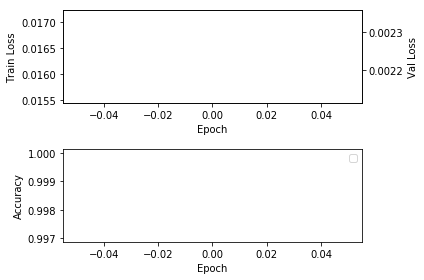

In [82]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
%matplotlib inline

NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    train_loss, train_acc = train_epoch(model, x_train, y_train)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = validate_epoch(model, x_train, y_train, class_weights)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    plot_losses(epoch, train_losses, train_accs, val_losses, val_accs)
    

In [117]:
predictions = []
true_labels = []
sample_weights = []
for x, y in get_shuffled_batches(x_test, y_test):
    prediction = model.predict_on_batch(x)
    predictions.append(prediction)
    true_labels.append(y)
    sample_weights.append(sample_weights_from_class_weights(class_weights, y))

In [118]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)
sample_weights = np.array(sample_weights)

In [119]:
predictions = np.argmax(predictions, axis=2)
true_labels = np.argmax(true_labels, axis=2)

In [120]:
predictions = np.reshape(predictions, predictions.shape[0])
true_labels = np.reshape(true_labels, true_labels.shape[0])
sample_weights = np.reshape(sample_weights, sample_weights.shape[0])

In [122]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

metrics = dict(
    precision = precision_score(true_labels, predictions, average=None),
    recall = recall_score(true_labels, predictions, average=None),
    f1 = f1_score(true_labels, predictions, average=None),
    accuracy_raw = accuracy_score(true_labels, predictions),
    accuracy_weighted = accuracy_score(true_labels, predictions, sample_weight=sample_weights),
    confusion = confusion_matrix(true_labels, predictions)
)

In [123]:
metrics

{'precision': array([0.61538462, 0.81481481, 0.92307692, 0.6       , 0.86206897,
        0.72      , 0.82352941, 0.90625   ]),
 'recall': array([0.72727273, 0.91666667, 0.75      , 0.69230769, 0.96153846,
        0.72      , 0.75675676, 0.82857143]),
 'f1': array([0.66666667, 0.8627451 , 0.82758621, 0.64285714, 0.90909091,
        0.72      , 0.78873239, 0.86567164]),
 'accuracy_raw': 0.7962962962962963,
 'accuracy_weighted': 0.7929515418502202,
 'confusion': array([[ 8,  1,  0,  1,  0,  0,  1,  0],
        [ 2, 22,  0,  0,  0,  0,  0,  0],
        [ 1,  0, 24,  2,  0,  2,  1,  2],
        [ 1,  4,  0, 18,  0,  3,  0,  0],
        [ 0,  0,  0,  0, 25,  0,  0,  1],
        [ 0,  0,  1,  4,  1, 18,  1,  0],
        [ 1,  0,  0,  5,  2,  1, 28,  0],
        [ 0,  0,  1,  0,  1,  1,  3, 29]], dtype=int64)}

In [126]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          block=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = np.average(cm)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if block:
        plt.show()

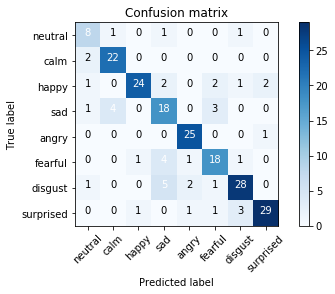

In [128]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

plot_confusion_matrix(metrics["confusion"], classes=emotions)

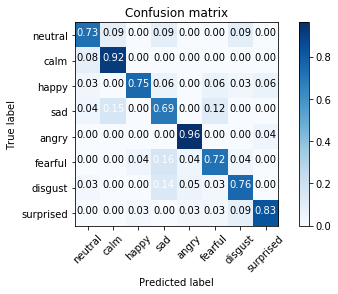

In [129]:
plot_confusion_matrix(metrics["confusion"], classes=emotions, normalize=True)